In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import np_utils, plot_model


import cv2
from glob import glob
from sklearn.utils import shuffle
from time import time


import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 資料在server的絕對路徑://data/examples/may_the_4_be_with_u/where_am_i
os.listdir("//data/aia-data/may_the_4_be_with_u/where_am_i")

['testset', 'train', 'mapping.txt', 'img-submission.csv']

In [3]:
os.listdir("//data/aia-data/may_the_4_be_with_u/where_am_i/train")[0:9]

['livingroom',
 'CALsuburb',
 'industrial',
 'kitchen',
 'PARoffice',
 'store',
 'street',
 'highway',
 'forest']

In [4]:
os.listdir("//data/aia-data/may_the_4_be_with_u/where_am_i/train/livingroom")[0:9]

['image_0059.jpg',
 'image_0138.jpg',
 'image_0102.jpg',
 'image_0133.jpg',
 'image_0084.jpg',
 'image_0087.jpg',
 'image_0187.jpg',
 'image_0153.jpg',
 'image_0079.jpg']

In [5]:
os.listdir("//data/aia-data/may_the_4_be_with_u/where_am_i/testset")[0:9]

['c638398a8fcb25b1cbb673c65879ce16b705f3f906d1df8bae5d445aa1f10bc7.jpg',
 '5f3f1ff593cd3c8611f06029f3fc2af0c0998824e422f6003d970f07bf16bb13.jpg',
 '8b2b5aafa0a9d50e998fa125bb3e7e99bb1fb24670dfdfef9736149107e4bc59.jpg',
 'e4d4c1a6ac7f58701768ff5a7c921c6681dbcaa581ea7dfb04a8a43a6b34696e.jpg',
 'e3a8c865c3d1a3e4f3e6c78c83c307e4faa194836a0f4bdbcc862c3783383585.jpg',
 'ced9af3bea24ff8111e0d4c7a5ac485a1c1f77976b4deb4fadc2030c52781365.jpg',
 '9546e37f87c238d1f6f137771a79c46e06bdf65fc294413cd2564d7dbc1ef14a.jpg',
 '35192a41a53915af5e19610e218661f9c2d854ee83bbd60429e24df9a38e8030.jpg',
 '312f3cac43994d873c3322cb7fc02ec2631cf97e572d60b1bee7dfdbfef5ee6f.jpg']

In [6]:
pd.read_csv('//data/aia-data/may_the_4_be_with_u/where_am_i/mapping.txt')[0:9]


,CALsuburb,9
0,PARoffice,7
1,bedroom,12
2,coast,10
3,forest,4
4,highway,14
5,industrial,2
6,insidecity,3
7,kitchen,0
8,livingroom,5


In [7]:
# 資料在 server 上的絕對路徑裡
data_dir_path = '//data/aia-data/may_the_4_be_with_u/where_am_i'

In [8]:
# Opening a file using "with" is as simple as: with open(filename) as file:
target_label_file_name = 'mapping.txt'

target_label_file_path = '/'.join((data_dir_path, target_label_file_name))
# 在 f 資料夾讀一筆，則 .splitlines():返回一個包含各列作為元素的列表，然後 line.split(', ') 代表用 ', ' 分隔相鄰列表
with open(target_label_file_path) as f:
    all_lines = [line.split(', ') for line in f.read().splitlines()]

# 將list 換成dic的形式
target_labels = dict()
for line in all_lines:
    target_class, target_label = line
    target_labels[target_class] = target_label

In [9]:
target_labels

{'CALsuburb': '9',
 'PARoffice': '7',
 'bedroom': '12',
 'coast': '10',
 'forest': '4',
 'highway': '14',
 'industrial': '2',
 'insidecity': '3',
 'kitchen': '0',
 'livingroom': '5',
 'mountain': '8',
 'opencountry': '6',
 'store': '11',
 'street': '1',
 'tallbuilding': '13'}

# Training Data

In [10]:
# 指定存放 train 資料集的資料夾
train_dir = '/'.join((data_dir_path, 'train'))
img_path_list = []
img_class_list = []
# 利用迴圈依序用字典的 key 找出該類別(key)的路徑，再透過 glob() 找出路徑下的所有文件，
# 並透過迴圈每找到一個文件，就在 img_class_list 裡增加一個該類的的 label
for key in target_labels.keys():
    for file_path in glob('{}/{}/*.jpg'.format(train_dir, key)):     # glob: 返回所有匹配的文件路徑列表
        img_class_list.append(target_labels[key])                    # {}.format() : 將()裡的東西，變成{}形式的字串
        img_path_list.append(file_path)

data_list = pd.DataFrame({'class': img_class_list, 'path': img_path_list})

In [11]:
data_list.head(10)

,class,path
0,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
1,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
2,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
3,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
4,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
5,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
6,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
7,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
8,9,//data/aia-data/may_the_4_be_with_u/where_am_i...
9,9,//data/aia-data/may_the_4_be_with_u/where_am_i...


In [12]:
# 改成list 形式 ，才能當 for 迴圈的 index
img_paths_list = data_list['path']
img_labels_list = data_list['class']
train_img_paths, valid_img_paths, y_train, y_valid = train_test_split(img_paths_list, img_labels_list, test_size=0.1)

In [13]:
print('Some training samples:\n----------------------')
print(train_img_paths.head())

print('\nSome training labels:\n---------------------')
print(y_train.head())

print('\nSome validation samples:\n------------------------')
print(valid_img_paths.head())

print('\nSome validation labels:\n-----------------------')
print(y_valid.head())

Some training samples:
----------------------
1471    //data/aia-data/may_the_4_be_with_u/where_am_i...
2566    //data/aia-data/may_the_4_be_with_u/where_am_i...
1906    //data/aia-data/may_the_4_be_with_u/where_am_i...
2492    //data/aia-data/may_the_4_be_with_u/where_am_i...
887     //data/aia-data/may_the_4_be_with_u/where_am_i...
Name: path, dtype: object

Some training labels:
---------------------
1471     0
2566     1
1906     8
2492    11
887     14
Name: class, dtype: object

Some validation samples:
------------------------
796     //data/aia-data/may_the_4_be_with_u/where_am_i...
2751    //data/aia-data/may_the_4_be_with_u/where_am_i...
193     //data/aia-data/may_the_4_be_with_u/where_am_i...
2913    //data/aia-data/may_the_4_be_with_u/where_am_i...
198     //data/aia-data/may_the_4_be_with_u/where_am_i...
Name: path, dtype: object

Some validation labels:
-----------------------
796      4
2751    13
193      7
2913    13
198      7
Name: class, dtype: object


# keras

In [14]:
num_classes = 15 #label 的類別數
epochs = 100
batch_size = 32

img_size = 224

In [15]:
def load_data(Gray2RGB=False, mean_proc=False, img_size=img_size, test_data = True):
    
#         """ Split the list into training set and validation set """
    
    X_train = []
    for path in train_img_paths:
        img = cv2.imread(path, 0)   # 讀取圖檔，後面的 0 代表讀取圖檔為灰階形式
        img = cv2.resize(img, (img_size, img_size))
        
        if Gray2RGB == True:        # 灰階轉 RGB 檔
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img = img.astype(np.float32) #將圖片轉成數字
            
        # 平均數處理    
        if mean_proc == 'VGG16_ImageNet':
            img = img - np.array([123.68, 116.779, 103.939]) # RGB channel 的平均數(官方給的)
            img = img[:,:,::-1]  # RGB 轉為 BGR， 因為 pre-train 好的 model，channel 為 BGR
            img = (img - np.min(img)) / np.max(img)
        if mean_proc == 'DenseNet':
            img /= 255.
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img - mean) / std
        else:
            img /= 255.
            img -= 0.5
            img *= 2.
            
        X_train.append(img)
    X_train = np.array(X_train, dtype=np.float32)
    
    X_valid = []
    if test_data == True:
        for path in valid_img_paths:
            img = cv2.imread(path, 0)
            img = cv2.resize(img, (img_size, img_size))

            if Gray2RGB == True:
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            
            img = img.astype(np.float32)
            
            if mean_proc == 'VGG16_ImageNet':
                img = img - np.array([123.68, 116.779, 103.939])
                img = img[:,:,::-1]  # RGB to BGR
                img = (img - np.min(img)) / np.max(img)
            if mean_proc == 'DenseNet':
                img /= 255.
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = (img - mean) / std
            else:
                img /= 255.
                img -= 0.5
                img *= 2.
            X_valid.append(img)
    X_valid = np.array(X_valid, dtype=np.float32)
    
    if Gray2RGB == False:
        X_train = np.reshape(X_train, X_train.shape+(1,))  # .shape+(1,) : 多加一個維度且數目是 1，為了顯示 channel 為一
        X_valid = np.reshape(X_valid, X_valid.shape+(1,))
   
    
    return X_train, X_valid

In [16]:
X_train, X_valid = load_data(Gray2RGB=False, mean_proc=False, img_size=224, test_data = True)

In [17]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)  #  num_classes: 總類別數
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 1)
(2686, 15)
(299, 224, 224, 1)
(299, 15)


In [19]:
# a classic CNN model
model_name = 'classic_CNN'
# The Sequential model is a linear stack of layers.
# A linear stack is a model without any branching. 
# Every layer has one input and output. The output of one layer is the input of the layer below it.
model = Sequential()
# keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1),
# activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
# kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 128)     0         
__________

In [20]:
path = 'saved_models'
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')

# Fit model with data augmentation

In [22]:
# Data generator with augmentation
## 定義一個產生器，在每看一個batch時，做資料增強，再fit model，實務上這樣做 model 可以看到更多樣的變化，
# 當然如果用事先資料增強的方法，當增強數據越多，結果也會越接近 realtime data augmentation，但儲存空間龐大
datagen = ImageDataGenerator(
    rotation_range=10,        # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,    # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,   # randomly shift images vertically (fraction of total height)
    shear_range=0.2,          
    zoom_range=0.2,
    horizontal_flip=True,     # randomly flip images
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)
# model 存檔的路徑
model_path = './saved_models/{}.h5'.format(model_name)
# 定義要 training 的時候需要記錄下來的結果
# monitor : 要監控的變數
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
# 定義 Early stopping 的函數
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
# 隨機從每一個 epoch當中抽出圖片做資料增強，然後才吐出 batch 的數量 fit model，但每一個 epoch 的數量不會改變喔
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.6040 - acc: 0.1601
Epoch 00001: val_loss improved from inf to 3.35259, saving model to ./saved_models/classic_CNN.h5
167/167 [==============================] - 17s 104ms/step - loss: 2.6006 - acc: 0.1614 - val_loss: 3.3526 - val_acc: 0.1037
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 2.2270 - acc: 0.2818
Epoch 00002: val_loss did not improve from 3.35259
167/167 [==============================] - 11s 68ms/step - loss: 2.2277 - acc: 0.2817 - val_loss: 3.5563 - val_acc: 0.1037
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 2.1094 - acc: 0.3220
Epoch 00003: val_loss improved from 3.35259 to 2.61904, saving model to ./saved_models/classic_CNN.h5
167/167 [==============================] - 12s 70ms/step - loss: 2.1068 - acc: 0.3231 - val_loss: 2.6190 - val_acc: 0.1773
Epoch 4/200
166/167 [============================>.] - ETA: 0s - loss: 2.0140 - acc: 0.3614
Epoch 00004

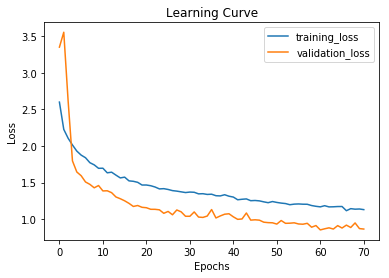

In [23]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

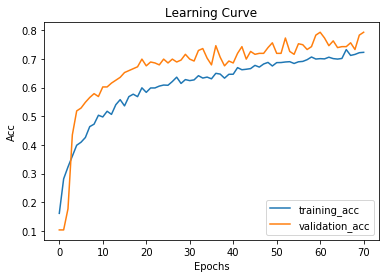

In [24]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# Testing Data

In [25]:
# 指定存放 test 資料集的資料夾
testset_dir = '/'.join((data_dir_path, 'testset'))
testset_list = []
test_id_list = []

for img_path in glob('{}/*.jpg'.format(testset_dir)):
    testset_list.append(img_path)
    id = img_path.split('/')[-1].split('.')[0]  # -1 表示圖片路徑的最後一個 part，也就是圖片名，由於圖片名有加副檔名，
    test_id_list.append(id)                     # 所以用 '.' 做切割，取第0個
testset_df = pd.DataFrame({'id': test_id_list, 'path': testset_list}).sort_values(by='id')

In [26]:
print('\nSome testing samples:\n------------------------')
print(testset_df.head())
print('\ncomplete path samples:\n------------------------')
print(testset_df['path'][0])


Some testing samples:
------------------------
                                                     id  \
439   001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...   
869   00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...   
1143  003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...   
355   013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...   
734   0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...   

                                                   path  
439   //data/aia-data/may_the_4_be_with_u/where_am_i...  
869   //data/aia-data/may_the_4_be_with_u/where_am_i...  
1143  //data/aia-data/may_the_4_be_with_u/where_am_i...  
355   //data/aia-data/may_the_4_be_with_u/where_am_i...  
734   //data/aia-data/may_the_4_be_with_u/where_am_i...  

complete path samples:
------------------------
//data/aia-data/may_the_4_be_with_u/where_am_i/testset/c638398a8fcb25b1cbb673c65879ce16b705f3f906d1df8bae5d445aa1f10bc7.jpg


In [27]:
def load_test_data(Gray2RGB=False, mean_proc=False, img_size=img_size):
    img_path_list = []
    #找出 rest data 的路徑
    for img_path in glob('{}/*.jpg'.format(testset_dir)):
        img_path_list.append(img_path)
        
    X_test = []
    X_id = []
    for path in img_path_list:
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (img_size, img_size))
        
        if Gray2RGB == True:
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = img.astype(np.float32)

        if mean_proc == 'VGG16_ImageNet':
            img = img - np.array([123.68, 116.779, 103.939])
            img = img[:,:,::-1]  # RGB to BGR
            img = (img - np.min(img)) / np.max(img)
        if mean_proc == 'DenseNet':
            img /= 255.
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img - mean) / std
        else:
            img /= 255.
            img -= 0.5
            img *= 2.
            
        img_id = path.split('/')[-1].split('.')[0]
        X_test.append(img)
        X_id.append(img_id)
        
    X_test = np.array(X_test, dtype=np.float32)
    
    if Gray2RGB == False:
        X_test = np.reshape(X_test, X_test.shape+(1,))
    
    return X_test, X_id

In [28]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.8527030027829684
Validation accuracy: 0.7926421400695342


# 重起 kernel 後，load 模型，省去之前訓練模型的部分，最後加上以下的code

In [29]:
another_model = tf.keras.models.load_model('./saved_models/classic_CNN.h5')

In [30]:
X_test, X_id = load_test_data()
y_test_pred = another_model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.head()

,id,class
439,001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...,12
869,00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...,4
1143,003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...,4
355,013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...,6
734,0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...,10


# 將 model 加上 Global Average Pooling

將最後面的全連接層替代成將各自的featuremap數值加總，在做平均，當作output

In [31]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
# 用 GlobalAveragePooling2D() 取代 Flatten()
model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

In [32]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.3016 - acc: 0.2471
Epoch 00001: val_loss improved from inf to 3.01177, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 16s 94ms/step - loss: 2.3017 - acc: 0.2471 - val_loss: 3.0118 - val_acc: 0.0936
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 1.9452 - acc: 0.3798
Epoch 00002: val_loss did not improve from 3.01177
167/167 [==============================] - 11s 67ms/step - loss: 1.9452 - acc: 0.3790 - val_loss: 3.3134 - val_acc: 0.0936
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 1.8062 - acc: 0.4441
Epoch 00003: val_loss improved from 3.01177 to 2.52484, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 11s 68ms/step - loss: 1.8064 - acc: 0.4430 - val_loss: 2.5248 - val_acc: 0.2074
Epoch 4/200
166/167 [============================>.] - ETA

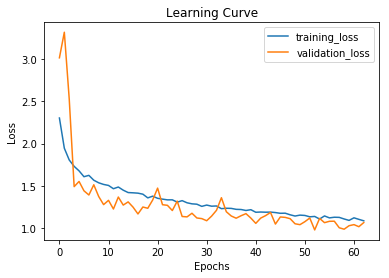

In [33]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

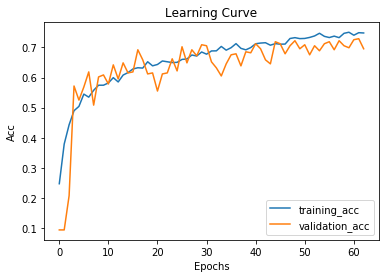

In [34]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [35]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.9813308644055523
Validation accuracy: 0.7056856195264836
